In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Import important packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing and EDA
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Read in the data
data = pd.read_csv(r'C:\Users\andre\OneDrive\Desktop\CS485-Final-Project\dataset\dataset.csv') 

# Read in the data(Mac)
# data = pd.read_csv(r'C:\Users\andre\OneDrive\Desktop\CS485-Final-Project\dataset\dataset.csv') 

In [4]:
# Let's look at basic information about the dataset
print("Dataset Shape:", data.shape)
print("\nFirst few rows:")
display(data.head())

Dataset Shape: (4424, 35)

First few rows:


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [5]:
# Check for missing values
print("\nMissing values:")
display(data.isnull().sum())


Missing values:


Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                     0
Curricular u

In [6]:
# Analyze data types
print("\nData types:")
display(data.dtypes)


Data types:


Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender                                              int64
Scholarship holder                                  int64
Age at enrollm

In [18]:
# Correct a column name that has a typo and replace single quotes with underscores
data.rename(columns = {"Nacionality": "Nationality", 
                           "Mother's qualification": "Mother_qualification", 
                           "Father's qualification": "Father_qualification", 
                           "Mother's occupation": "Mother_occupation",
                           "Father's occupation": "Father_occupation", 
                           "Age at enrollment": "Age"}, inplace = True)

# Replace white space in the column names with underscore
data.columns = data.columns.str.replace(' ', '_')

# Remove the parenthesis
data.columns = data.columns.str.replace('(', '')
data.columns = data.columns.str.replace(')', '')

In [19]:
# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Application_order', 'Course',
      'Daytime/evening_attendance', 'Previous_qualification', 'Nationality',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation', 'Displaced', 'Educational_special_needs', 'Debtor',
       'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
      'International', 'Target']

data[col] = data[col].astype('category')

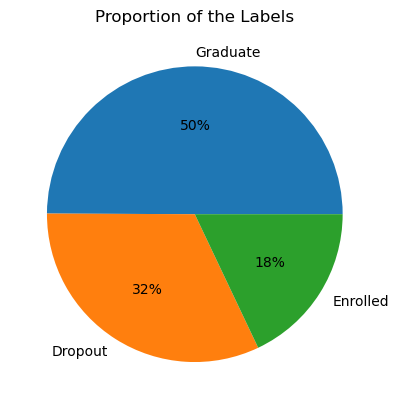

In [21]:
# Check the proportion of the labels in the target variable
labels = data['Target'].value_counts().index
values = data['Target'].value_counts().values

plt.pie(values, labels = labels, 
        autopct = '%1.0f%%')
plt.title('Proportion of the Labels');

In [25]:
# Encode the labels as ordinal data (0 - 'Dropout', 1 - 'Enrolled', and 2 - 'Graduate') 
data['Target_encoded'] = OrdinalEncoder(categories = [['Dropout', 'Enrolled', 'Graduate']]).fit_transform(data[['Target']])

# Drop 'Target' variable
data.drop('Target', axis = 1, inplace = True)

In [26]:
# list of categorical features
cats = ['Marital_status', 'Application_mode', 'Application_order', 
        'Course','Daytime/evening_attendance', 'Previous_qualification', 
        'Nationality','Mother_qualification', 'Father_qualification', 
        'Mother_occupation', 'Father_occupation', 'Displaced', 
        'Educational_special_needs', 'Debtor','Tuition_fees_up_to_date', 
        'Gender', 'Scholarship_holder','International']

# Get the p-values from Chi-Square indenpendence tests
p_value = []

for col in cats:
    crosstable = pd.crosstab(index = data[col], 
                             columns = data['Target_encoded'])
    p = chi2_contingency(crosstable)[1]
    p_value.append(p)

chi2_result = pd.DataFrame({
    'Variable': cats,
    'P_value': [round(ele, 5) for ele in p_value]
})

chi2_result = chi2_result.sort_values('P_value')

chi2_result

,Variable,P_value
0,Marital_status,0.00000
15,Gender,0.00000
14,Tuition_fees_up_to_date,0.00000
13,Debtor,0.00000
11,Displaced,0.00000
10,Father_occupation,0.00000
9,Mother_occupation,0.00000
16,Scholarship_holder,0.00000
8,Father_qualification,0.00000
5,Previous_qualification,0.00000


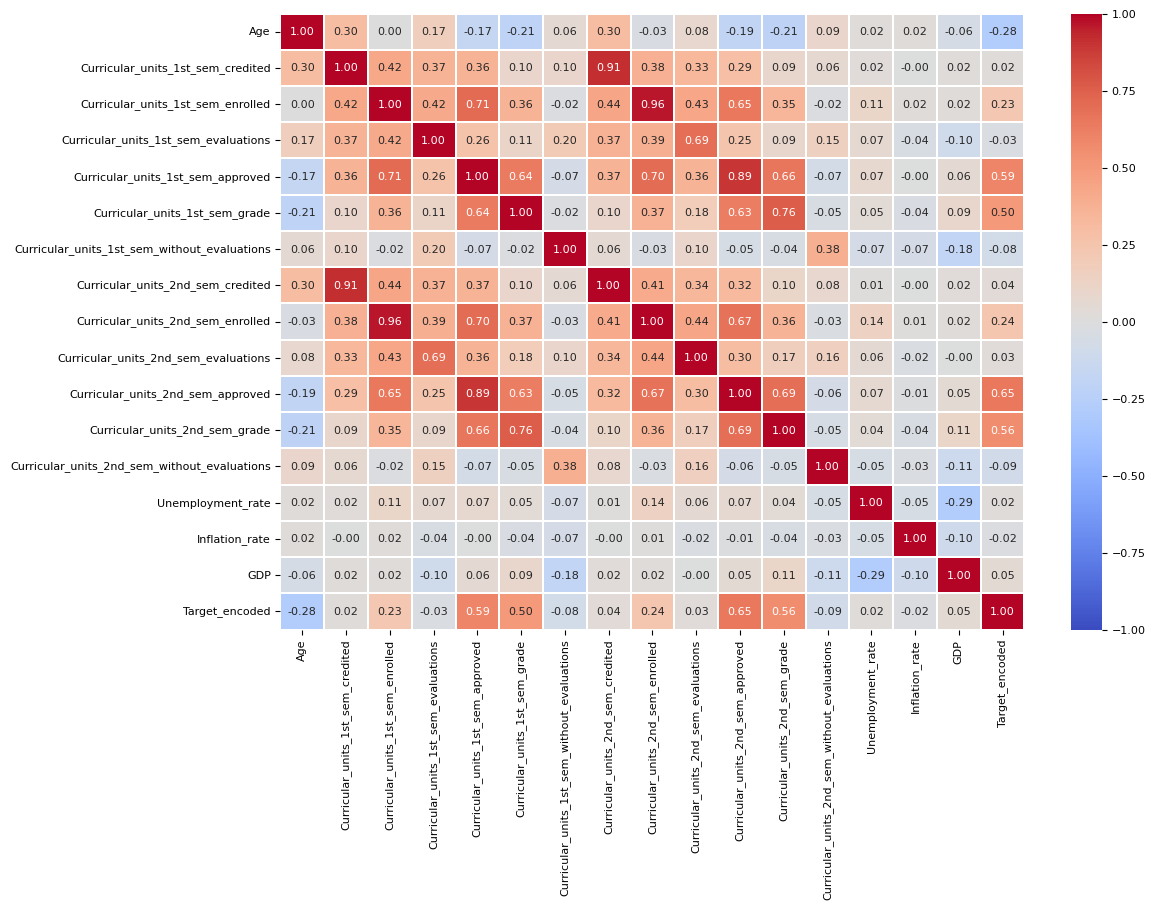

In [44]:
# Numeric features
num_features = data[['Age',
       'Curricular_units_1st_sem_credited',
       'Curricular_units_1st_sem_enrolled',
       'Curricular_units_1st_sem_evaluations',
       'Curricular_units_1st_sem_approved', 
       'Curricular_units_1st_sem_grade',
       'Curricular_units_1st_sem_without_evaluations',
       'Curricular_units_2nd_sem_credited',
       'Curricular_units_2nd_sem_enrolled',
       'Curricular_units_2nd_sem_evaluations',
       'Curricular_units_2nd_sem_approved', 
       'Curricular_units_2nd_sem_grade',
       'Curricular_units_2nd_sem_without_evaluations', 
       'Unemployment_rate', 'Inflation_rate', 'GDP', 'Target_encoded']]

# Heatmap of correlation matrix
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 8})
hm = sns.heatmap(num_features.corr(method = 'spearman'), 
                 cmap = 'coolwarm', annot = True, fmt = '.2f', 
                 linewidths = .2, vmin = -1, vmax = 1, center = 0)

In [66]:
def engineer_semester_features(df):
    """
    Create more meaningful features from semester data instead of dropping
    """
    # Create copy to avoid modifying original
    data = df.copy()
    
    # Calculate semester-over-semester changes
    data['grade_improvement'] = (data['Curricular_units_2nd_sem_grade'] - data['Curricular_units_1st_sem_grade']).fillna(0)
    
    # Calculate approval rate changes
    data['approval_rate_1st'] = (data['Curricular_units_1st_sem_approved'] / data['Curricular_units_1st_sem_enrolled']).fillna(0)
    data['approval_rate_2nd'] = (data['Curricular_units_2nd_sem_approved'] / data['Curricular_units_2nd_sem_enrolled']).fillna(0)
    data['approval_rate_change'] = (data['approval_rate_2nd'] - data['approval_rate_1st']).fillna(0)
    data['approval_rate_average'] = data[['Curricular_units_1st_sem_approved', 'Curricular_units_2nd_sem_approved']].mean(axis = 1)
    
    #AVERAGE enrolled
    data['avg_enrolled'] = data[['Curricular_units_1st_sem_enrolled', 'Curricular_units_2nd_sem_enrolled']].mean(axis = 1)

    
    # Calculate consistency score
    data['performance_consistency'] = 1 - abs(data['approval_rate_2nd'] - data['approval_rate_1st'])

    # Create economic index
    data['economic_index'] = (data['Unemployment_rate'] * -1 + 
                            data['GDP'] * 2 - 
                            data['Inflation_rate'])
        
    return data

stud_selected = engineer_semester_features(data)

display(stud_selected)

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Mother_qualification,Father_qualification,Mother_occupation,Father_occupation,...,Target_encoded,grade_improvement,approval_rate_1st,approval_rate_2nd,approval_rate_change,relative_performance,performance_consistency,approval_rate_average,avg_enrolled,economic_index
0,1,8,5,2,1,1,13,10,6,10,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,-8.72
1,1,6,1,11,1,1,1,3,4,4,...,2.0,-0.333333,1.000000,1.000000,0.000000,0.976190,1.000000,6.0,6.0,-12.02
2,1,1,5,5,1,1,22,27,10,10,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,6.0,-8.72
3,1,8,2,15,1,1,23,27,6,4,...,2.0,-1.028571,1.000000,0.833333,-0.166667,0.923404,0.833333,5.5,6.0,-14.84
4,2,12,1,3,0,1,22,28,10,10,...,2.0,0.666667,0.833333,1.000000,0.166667,1.054054,0.833333,5.5,6.0,-12.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,6,5,...,2.0,-0.933333,0.833333,0.833333,0.000000,0.931373,1.000000,5.0,6.0,-26.42
4420,1,1,2,15,1,1,1,1,10,10,...,0.0,-1.000000,1.000000,0.333333,-0.666667,0.916667,0.333333,4.0,6.0,-7.66
4421,1,1,1,12,1,1,22,27,10,10,...,0.0,-1.412500,1.000000,0.125000,-0.875000,0.905281,0.125000,4.0,7.5,-12.02
4422,1,1,1,9,1,1,22,27,8,5,...,2.0,-1.800000,1.000000,1.000000,0.000000,0.869565,1.000000,5.0,5.0,-14.84


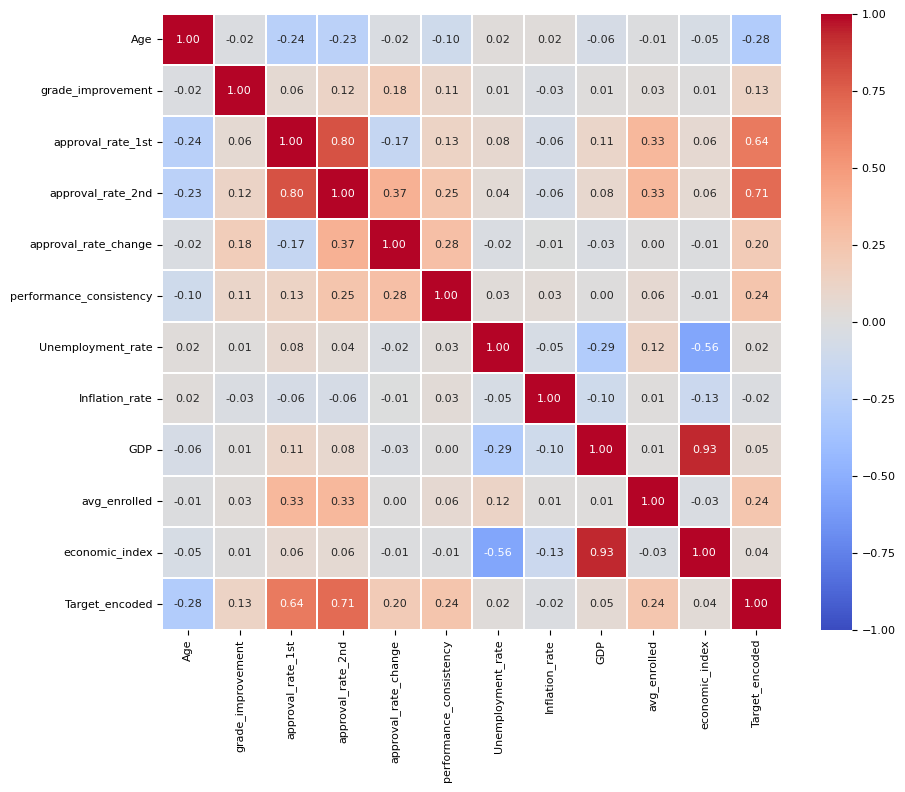

In [68]:

num_features = stud_selected[['Age', 'grade_improvement', 'approval_rate_1st', 
                              'approval_rate_2nd', 'approval_rate_change', 'performance_consistency', 
                              'Unemployment_rate', 'Inflation_rate', 
                              'GDP', 'avg_enrolled', 'economic_index', 'Target_encoded']]

plt.figure(figsize = (10, 8))
plt.rcParams.update({'font.size': 8})
sns.heatmap(num_features.corr(method = 'spearman'), vmin = -1, vmax = 1, center = 0, 
            cmap = 'coolwarm', fmt = '.2f', linewidths = .2, annot = True);

In [69]:
#drop columns with very little correlation to Target
stud_selected =  stud_selected.drop(['Unemployment_rate', 'Inflation_rate', 
                              'GDP', 'economic_index', 'relative_performance'], axis = 1)

display(stud_selected)

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Mother_qualification,Father_qualification,Mother_occupation,Father_occupation,...,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Target_encoded,grade_improvement,approval_rate_1st,approval_rate_2nd,approval_rate_change,performance_consistency,approval_rate_average,avg_enrolled
0,1,8,5,2,1,1,13,10,6,10,...,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0
1,1,6,1,11,1,1,1,3,4,4,...,13.666667,0,2.0,-0.333333,1.000000,1.000000,0.000000,1.000000,6.0,6.0
2,1,1,5,5,1,1,22,27,10,10,...,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,6.0
3,1,8,2,15,1,1,23,27,6,4,...,12.400000,0,2.0,-1.028571,1.000000,0.833333,-0.166667,0.833333,5.5,6.0
4,2,12,1,3,0,1,22,28,10,10,...,13.000000,0,2.0,0.666667,0.833333,1.000000,0.166667,0.833333,5.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,6,5,...,12.666667,0,2.0,-0.933333,0.833333,0.833333,0.000000,1.000000,5.0,6.0
4420,1,1,2,15,1,1,1,1,10,10,...,11.000000,0,0.0,-1.000000,1.000000,0.333333,-0.666667,0.333333,4.0,6.0
4421,1,1,1,12,1,1,22,27,10,10,...,13.500000,0,0.0,-1.412500,1.000000,0.125000,-0.875000,0.125000,4.0,7.5
4422,1,1,1,9,1,1,22,27,8,5,...,12.000000,0,2.0,-1.800000,1.000000,1.000000,0.000000,1.000000,5.0,5.0


In [70]:
stud_selected = stud_selected.drop(columns = [ 'Curricular_units_1st_sem_credited', 
                                              'Curricular_units_1st_sem_enrolled', 
                                              'Curricular_units_1st_sem_evaluations', 
                                              'Curricular_units_1st_sem_approved', 
                                              'Curricular_units_1st_sem_grade', 
                                              'Curricular_units_1st_sem_without_evaluations', 
                                              'Curricular_units_2nd_sem_credited', 
                                              'Curricular_units_2nd_sem_enrolled', 
                                              'Curricular_units_2nd_sem_evaluations', 
                                              'Curricular_units_2nd_sem_approved', 
                                              'Curricular_units_2nd_sem_grade', 
                                              'Curricular_units_2nd_sem_without_evaluations'])

In [71]:
display(stud_selected)
print(stud_selected.columns.tolist())

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Mother_qualification,Father_qualification,Mother_occupation,Father_occupation,...,Scholarship_holder,Age,Target_encoded,grade_improvement,approval_rate_1st,approval_rate_2nd,approval_rate_change,performance_consistency,approval_rate_average,avg_enrolled
0,1,8,5,2,1,1,13,10,6,10,...,0,20,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0
1,1,6,1,11,1,1,1,3,4,4,...,0,19,2.0,-0.333333,1.000000,1.000000,0.000000,1.000000,6.0,6.0
2,1,1,5,5,1,1,22,27,10,10,...,0,19,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,6.0
3,1,8,2,15,1,1,23,27,6,4,...,0,20,2.0,-1.028571,1.000000,0.833333,-0.166667,0.833333,5.5,6.0
4,2,12,1,3,0,1,22,28,10,10,...,0,45,2.0,0.666667,0.833333,1.000000,0.166667,0.833333,5.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,6,5,...,0,19,2.0,-0.933333,0.833333,0.833333,0.000000,1.000000,5.0,6.0
4420,1,1,2,15,1,1,1,1,10,10,...,0,18,0.0,-1.000000,1.000000,0.333333,-0.666667,0.333333,4.0,6.0
4421,1,1,1,12,1,1,22,27,10,10,...,1,30,0.0,-1.412500,1.000000,0.125000,-0.875000,0.125000,4.0,7.5
4422,1,1,1,9,1,1,22,27,8,5,...,1,20,2.0,-1.800000,1.000000,1.000000,0.000000,1.000000,5.0,5.0


['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime/evening_attendance', 'Previous_qualification', 'Mother_qualification', 'Father_qualification', 'Mother_occupation', 'Father_occupation', 'Displaced', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age', 'Target_encoded', 'grade_improvement', 'approval_rate_1st', 'approval_rate_2nd', 'approval_rate_change', 'performance_consistency', 'approval_rate_average', 'avg_enrolled']


In [72]:
# Find all infinite values in the dataset
def find_infinite_values(df):
    """
    Print detailed information about infinite values in the dataframe
    """
    # Find columns with infinite values
    inf_cols = df.columns[(df == np.inf).any() | (df == -np.inf).any()]
    
    print("1. Columns containing infinite values:")
    for col in inf_cols:
        inf_count = df[df[col].isin([np.inf, -np.inf])][col].count()
        if inf_count > 0:
            print(f"\nColumn '{col}':")
            print(f"Number of infinite values: {inf_count}")
            
            # Display rows with infinite values in this column
            inf_rows = df[df[col].isin([np.inf, -np.inf])]
            print("\nRows containing infinite values:")
            display(inf_rows)
            
            # Show some statistics for this column
            print(f"\nStatistics for column {col}:")
            print(df[col].describe())

# Find all infinite and very large values
def find_extreme_values(df):
    """
    Print information about extreme values in the dataframe
    """
    print("\n2. Extreme Value Analysis:")
    for col in df.select_dtypes(include=np.number).columns:
        # Get max and min values
        max_val = df[col].max()
        min_val = df[col].min()
        
        # Check if values are extreme
        if max_val > 1e10 or min_val < -1e10:
            print(f"\nColumn '{col}' has extreme values:")
            print(f"Max: {max_val}")
            print(f"Min: {min_val}")
            
            # Show rows with extreme values
            extreme_rows = df[
                (df[col] > 1e10) | 
                (df[col] < -1e10)
            ]
            if not extreme_rows.empty:
                print("\nRows with extreme values:")
                display(extreme_rows)

# Use both functions
print("Finding infinite and extreme values in the dataset...")
find_infinite_values(stud_selected)
find_extreme_values(stud_selected)

# Optional: Display summary of all numerical columns
print("\n3. Summary of all numerical columns:")
display(stud_selected.describe())

Finding infinite and extreme values in the dataset...
1. Columns containing infinite values:

2. Extreme Value Analysis:

3. Summary of all numerical columns:


,Age,Target_encoded,grade_improvement,approval_rate_1st,approval_rate_2nd,approval_rate_change,performance_consistency,approval_rate_average,avg_enrolled
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,23.265145,1.178119,-0.410616,0.697885,0.660356,-0.037529,0.897958,4.571203,6.251356
std,7.587816,0.888243,2.890376,0.365247,0.382964,0.189446,0.163962,2.980306,2.304411
min,17.000000,0.000000,-16.142857,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,-0.600000,0.500000,0.400000,-0.007576,0.833333,2.500000,5.000000
50%,20.000000,1.000000,0.000000,0.833333,0.833333,0.000000,1.000000,5.000000,6.000000
75%,25.000000,2.000000,0.452381,1.000000,1.000000,0.000000,1.000000,6.000000,7.000000
max,70.000000,2.000000,16.000000,1.000000,1.000000,1.000000,1.000000,21.500000,23.000000


In [86]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd

# Prepare the data
X = stud_selected.drop('Target_encoded', axis=1)
y = stud_selected['Target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_distributions = {
    'n_estimators': randint(500, 2000),
    'max_depth': range(5, 15),  # reduced from 18
    'min_samples_split': randint(10, 40),  # increased from 5
    'min_samples_leaf': randint(5, 20),  # increased from 2
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'bootstrap': [True],
    'max_samples': [0.4, 0.5, 0.6],  # narrower range
    'ccp_alpha': uniform(0.001, 0.01)  # add pruning
}

scoring = {
    'f1': make_scorer(f1_score, average='weighted'),
    'accuracy': 'accuracy'
}

rf = RandomForestClassifier(random_state=42)
# Increase n_iter for more thorough search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=300,  # increased from 200
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Fit the random search
random_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best model
best_rf = random_search.best_estimator_

# Evaluate on both train and test sets
train_score = best_rf.score(X_train, y_train)
test_score = best_rf.score(X_test, y_test)
print("\nTrain set score:", train_score)
print("Test set score:", test_score)

# Feature importance with standard deviations
importances = best_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances,
    'std': std
}).sort_values('importance', ascending=False)

print("\nFeature Importances with tuned model:")
print(feature_importance)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0013700763471549264, 'class_weight': 'balanced', 'max_depth': 12, 'max_features': 'sqrt', 'max_samples': 0.4, 'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 1304}
Best cross-validation score: 0.7502153605191028

Train set score: 0.7821418479796552
Test set score: 0.7367231638418079

Feature Importances with tuned model:
                       feature  importance       std
18           approval_rate_2nd    0.218941  0.165882
21       approval_rate_average    0.163246  0.142874
17           approval_rate_1st    0.157211  0.132893
12     Tuition_fees_up_to_date    0.056985  0.049084
20     performance_consistency    0.055581  0.044116
15                         Age    0.046708  0.030700
16           grade_improvement    0.046607  0.030838
19        approval_rate_change    0.043970  0.038148
3                       Course    0.037219  0.019675
22            

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

'''Fitting 5 folds for each of 200 candidates, totalling 1000 fits

Best parameters: {'bootstrap': False, 'class_weight': None, 'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 797}
Best cross-validation score: 0.7781830604367943
'''

# Split the data
X = stud_selected.drop('Target_encoded', axis=1)  # Remove target variable
y = stud_selected['Target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Calculate permutation importance
result = permutation_importance(
    rf, 
    X_test, 
    y_test,
    n_repeats=10,  # Number of times to permute/shuffle each feature
    random_state=42
)

# Create a dataframe of feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Importance_std': result.importances_std
}).sort_values('Importance', ascending=False)

print("Feature Importances:")
print(feature_importance)

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.errorbar(
    range(len(feature_importance)), 
    feature_importance['Importance'],
    yerr=feature_importance['Importance_std'],
    fmt='o'
)
plt.xticks(range(len(feature_importance)), feature_importance['Feature'], rotation=45, ha='right')
plt.title('Feature Importance (with standard deviation)')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 